<a href="https://colab.research.google.com/github/racoope70/daytrading-with-ml/blob/main/tsla_td3_vs_buyhold_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip uninstall -y protobuf tensorflow gym keras torch torchvision torchaudio || true
!pip install protobuf==3.20.3 tensorflow==2.18.0 stable-baselines3[extra] gymnasium gym-anytrading yfinance xgboost joblib matplotlib pandas numpy scipy scikit-learn imblearn
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124


Found existing installation: protobuf 3.20.3
Uninstalling protobuf-3.20.3:
  Successfully uninstalled protobuf-3.20.3
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: keras 3.9.1
Uninstalling keras-3.9.1:
  Successfully uninstalled keras-3.9.1
Found existing installation: torch 2.6.0
Uninstalling torch-2.6.0:
  Successfully uninstalled torch-2.6.0
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
  Using cached tensorflow-2.18.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached keras-3.9.1-py3-none-any.whl.metadata (6.1 kB)
  Using cached to

Looking in indexes: https://download.pytorch.org/whl/cu124
  Using cached https://download.pytorch.org/whl/cu124/torchvision-0.21.0%2Bcu124-cp311-cp311-linux_x86_64.whl.metadata (6.1 kB)
  Using cached https://download.pytorch.org/whl/cu124/torchaudio-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl.metadata (6.6 kB)
Using cached https://download.pytorch.org/whl/cu124/torchvision-0.21.0%2Bcu124-cp311-cp311-linux_x86_64.whl (7.3 MB)
Using cached https://download.pytorch.org/whl/cu124/torchaudio-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl (3.4 MB)
ERROR: Operation cancelled by user
^C


[*********************100%***********************]  1 of 1 completed


Using cuda device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 155      |
|    time_elapsed    | 126      |
|    total_timesteps | 19664    |
| train/             |          |
|    actor_loss      | 3.34     |
|    critic_loss     | 0.0107   |
|    learning_rate   | 0.0001   |
|    n_updates       | 19563    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 155      |
|    time_elapsed    | 252      |
|    total_timesteps | 39328    |
| train/             |          |
|    actor_loss      | 3.05     |
|    critic_loss     | 0.101    |
|    learning_rate   | 0.0001   |
|    n_updates       | 39227    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 12       |
|    fps             | 156      |
|    time_elapsed    | 377    

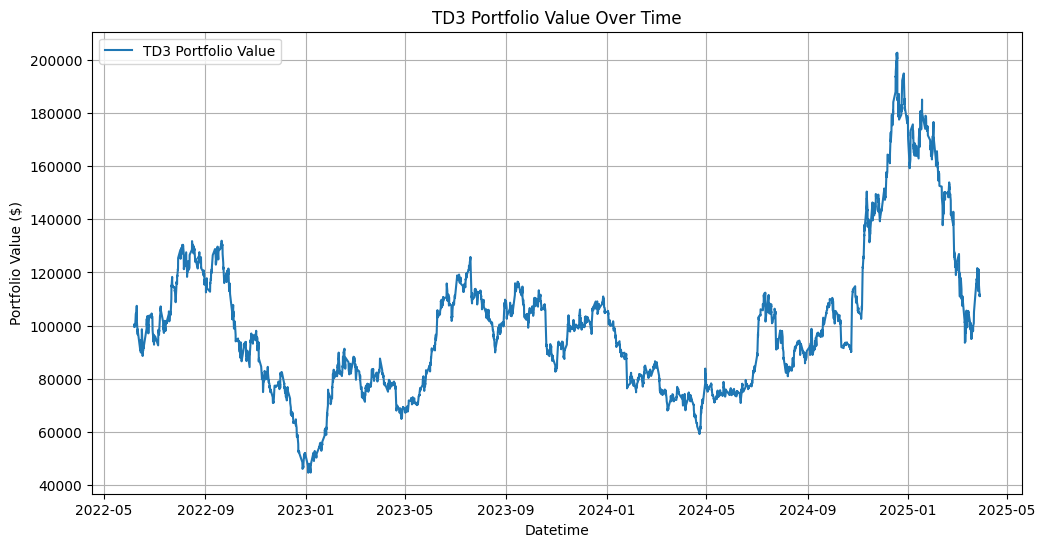

TD3 Portfolio results saved to: TSLA_td3_v1_2025-03-30.json
Trade log saved to CSV: TSLA_td3_v1_2025-03-30.csv


In [6]:
# Set Correct CUDA Paths
import os
os.environ['CUDA_HOME'] = '/usr/local/cuda-12.4'
os.environ['PATH'] += ':/usr/local/cuda-12.4/bin'
os.environ['LD_LIBRARY_PATH'] += ':/usr/local/cuda-12.4/lib64'

# Import Required Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import gymnasium as gym
import gym_anytrading
from stable_baselines3 import TD3
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium.spaces import Box
import matplotlib.pyplot as plt
from datetime import datetime
import json
import time
import torch

# Download and Clean Stock Data
def clean_stock_data(df):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    df.rename(columns=lambda x: x.capitalize(), inplace=True)
    df.rename(columns={'Adj Close': 'Close'}, inplace=True)

    required_columns = ['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']
    df = df[[col for col in required_columns if col in df.columns]]

    df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
    df.dropna(subset=['Datetime', 'Close'], inplace=True)
    df.sort_values(by='Datetime', inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

# Load Stock Data (TSLA - 720 days, 1 hour interval)
df_live = yf.download("TSLA", period="720d", interval="1h")
df_live.reset_index(inplace=True)
df = clean_stock_data(df_live)

# Feature Engineering (Technical Indicators)
def compute_technical_indicators(df):
    df['ATR'] = (df['High'] - df['Low']).rolling(window=14).mean()
    df['EMA_10'] = df['Close'].ewm(span=10).mean()
    df['EMA_50'] = df['Close'].ewm(span=50).mean()
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()

    macd_fast = df['Close'].ewm(span=12).mean()
    macd_slow = df['Close'].ewm(span=26).mean()
    df['MACD_Line'] = macd_fast - macd_slow
    df['MACD_Signal'] = df['MACD_Line'].ewm(span=9).mean()
    df['MACD_Hist'] = df['MACD_Line'] - df['MACD_Signal']

    delta = df['Close'].diff()
    gain = delta.clip(lower=0).rolling(window=14).mean()
    loss = -delta.clip(upper=0).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    df['Volume_Avg'] = df['Volume'].rolling(window=20).mean()
    df['ADX'] = abs(df['High'] - df['Low']).rolling(window=14).mean()

    df.dropna(inplace=True)
    return df

df = compute_technical_indicators(df)

# Custom Continuous Trading Environment
class ContinuousTradingEnv(gym_anytrading.envs.StocksEnv):
    def __init__(self, df, frame_bound, window_size):
        super().__init__(df=df, frame_bound=frame_bound, window_size=window_size)
        self.action_space = Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = action[0]

        # Map continuous action to discrete action
        if action < -0.3:
            discrete_action = 0  # SELL
        elif action > 0.3:
            discrete_action = 1  # BUY
        else:
            discrete_action = 2  # HOLD

        return super().step(discrete_action)

# Frame Bound Setup
frame_bound = (50, len(df))
window_size = 10

# Initialize Custom Trading Environment for TD3
env = ContinuousTradingEnv(df=df, frame_bound=frame_bound, window_size=window_size)
env = DummyVecEnv([lambda: env])

# Define and Train TD3 Model
td3_model = TD3(
    "MlpPolicy",
    env,
    learning_rate=1e-4,
    buffer_size=1000000,
    batch_size=256,
    gamma=0.995,
    policy_delay=2,
    verbose=1,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Train TD3 Model
start_time = time.time()
td3_model.learn(total_timesteps=100000)
print(f"Training Complete in {time.time() - start_time:.2f} seconds")

# Save TD3 Model
model_save_path = '/content/drive/My Drive/td3_tsla_model.zip'
td3_model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

# Run TD3 Trading Strategy
obs = env.reset()
trade_log_td3 = []
buy_price = None

for i in range(len(df) - 50):
    action, _ = td3_model.predict(obs)
    action_value = action[0]

    if action_value > 0.3 and buy_price is None:
        trade_log_td3.append("BUY")
        buy_price = df['Close'].iloc[i + 50]
    elif action_value < -0.3 and buy_price is not None:
        trade_log_td3.append("SELL")
        buy_price = None
    else:
        trade_log_td3.append("HOLD")

# Handle Length Mismatch with Padding
df.loc[df.index[:50], "TD3_Trade_Signal"] = "HOLD"  # Pad initial 50 rows
df.loc[df.index[50:50 + len(trade_log_td3)], "TD3_Trade_Signal"] = trade_log_td3

# Backtesting and Portfolio Calculation
initial_balance = 100000
balance_td3 = initial_balance
position = 0
portfolio_values_td3 = []

for i, trade in enumerate(trade_log_td3):
    price = df['Close'].iloc[i + 50]

    if trade == "BUY" and position == 0:
        position = balance_td3 / price
        balance_td3 = 0
    elif trade == "SELL" and position > 0:
        balance_td3 = position * price
        position = 0

    portfolio_values_td3.append(balance_td3 if balance_td3 > 0 else position * price)

final_balance_td3 = portfolio_values_td3[-1]
final_balance_hold = (initial_balance / df['Close'].iloc[50]) * df['Close'].iloc[-1]

# Compute Performance Metrics for TD3
results_df_td3 = pd.DataFrame({'Date': df['Datetime'].iloc[50:], 'Portfolio Value': portfolio_values_td3})
results_df_td3['Daily Return'] = results_df_td3['Portfolio Value'].pct_change().fillna(0)

td3_cumulative_return = ((results_df_td3['Portfolio Value'].iloc[-1] / initial_balance) - 1) * 100
td3_sharpe_ratio = (results_df_td3['Daily Return'].mean() / results_df_td3['Daily Return'].std()) * np.sqrt(252) if results_df_td3['Daily Return'].std() != 0 else 0
td3_max_drawdown = ((results_df_td3['Portfolio Value'].cummax() - results_df_td3['Portfolio Value']) / results_df_td3['Portfolio Value'].cummax()).max() * 100

# Final Results Summary
print("\nFINAL RESULTS COMPARISON:")

print("**Reinforcement Learning (TD3)**")
print(f"TD3 Final Portfolio Value: ${final_balance_td3:,.2f}")
print(f"TD3 Cumulative Return: {td3_cumulative_return:.2f}%")
print(f"TD3 Sharpe Ratio: {td3_sharpe_ratio:.2f}")
print(f"TD3 Max Drawdown: {td3_max_drawdown:.2f}%")
print(f"TD3 Trade Log (First 10): {trade_log_td3[:10]} ...")

print("\n**Buy & Hold Baseline**")
print(f"Buy & Hold Final Portfolio Value: ${final_balance_hold:,.2f}")

# Declare Winner Based on Portfolio Performance
winner = "TD3" if final_balance_td3 > final_balance_hold else "Buy & Hold"
print(f"\n**Best Strategy Based on Final Portfolio Value: {winner}!**")

# Plot Portfolio Value Over Time
plt.figure(figsize=(12, 6))
plt.plot(results_df_td3['Date'], results_df_td3['Portfolio Value'], label='TD3 Portfolio Value')
plt.xlabel('Datetime')
plt.ylabel('Portfolio Value ($)')
plt.title('TD3 Portfolio Value Over Time')
plt.legend()
plt.grid()
plt.show()

# Save Results with Naming Convention
def generate_filename(stock="TSLA", model="td3", version="v1", ext="json", use_date=True):
    date_str = datetime.now().strftime("%Y-%m-%d") if use_date else ""
    return f"{stock}_{model}_{version}{'_' + date_str if use_date else ''}.{ext}"

def save_td3_results(stock, final_balance_td3, td3_cumulative_return, td3_sharpe_ratio, td3_max_drawdown, trade_log_td3, version="v1"):
    # Save to JSON
    results_path_json = generate_filename(stock, "td3", version, "json")
    with open(results_path_json, "w") as f:
        json.dump({
            "model_name": "TD3",
            "final_value": final_balance_td3,
            "cumulative_return": td3_cumulative_return,
            "sharpe_ratio": td3_sharpe_ratio,
            "max_drawdown": td3_max_drawdown,
            "trade_log": trade_log_td3[:10]  # Save only first 10 trades for brevity
        }, f, indent=2)

    # Save Trade Log to CSV
    results_path_csv = generate_filename(stock, "td3", version, "csv")
    pd.DataFrame(trade_log_td3, columns=["Trade Signal"]).to_csv(results_path_csv, index=False)

    print(f"TD3 Portfolio results saved to: {results_path_json}")
    print(f"Trade log saved to CSV: {results_path_csv}")

# Save TD3 Results
save_td3_results(
    stock="TSLA",
    final_balance_td3=final_balance_td3,
    td3_cumulative_return=td3_cumulative_return,
    td3_sharpe_ratio=td3_sharpe_ratio,
    td3_max_drawdown=td3_max_drawdown,
    trade_log_td3=trade_log_td3
)
